In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
from fastai.text import *
import pickle
import pandas as pd
import html

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [3]:
PATH=Path('/home/paperspace/data/mimic-iii')
LM_PATH=PATH/'exp-4'

In [4]:
trn_ids = np.load(LM_PATH/'trn_ids_concat.npy')
val_ids = np.load(LM_PATH/'val_ids_concat.npy')

In [5]:
with open(LM_PATH/'itos.pickle', 'rb') as handle:
    itos = pickle.load(handle)
    
vocab_size=len(itos)

In [6]:
em_sz,nh,nl = 400,1150,3
bptt, bs = 70, 64

In [7]:
trn_dl = LanguageModelLoader(trn_ids, bs, bptt)
val_dl = LanguageModelLoader(val_ids, bs, bptt)
md = LanguageModelData(PATH, 0, vocab_size, trn_dl, val_dl, bs=bs, bptt=bptt)

In [8]:
drops = np.array([0.25, 0.1, 0.2, 0.02, 0.15])*0.5

In [9]:
opt_fn = partial(optim.Adam, betas=(0.8,0.99))
learner= md.get_model(opt_fn, em_sz, nh, nl,
    dropouti=drops[0], dropout=drops[1], wdrop=drops[2], dropoute=drops[3], dropouth=drops[4])
learner.metrics = [accuracy]
learner.clip=0.12
learner.unfreeze()
learner.reg_fn=partial(seq2seq_reg, alpha=2, beta=1)
wd = 1e-7

In [10]:
learner.lr_find(end_lr=1000)

 46%|████▌     | 13516/29389 [1:06:34<1:18:11,  3.38it/s, loss=9.85]

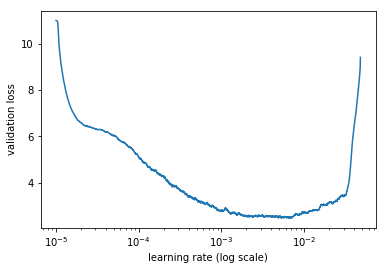

In [11]:
learner.sched.plot()

In [12]:
lr = 10e-3

In [13]:
learner.fit(lr, 1, cycle_len=12, use_clr_beta=(10,10,0.95,0.85))l

epoch      trn_loss   val_loss   accuracy                           
    0      2.329446   2.395113   0.546113  
    1      2.382126   2.374771   0.547977                           
    2      2.384268   2.349232   0.55244                            
    3      2.370828   2.377182   0.548708                           
    4      2.466097   2.413821   0.544219                           
    5      2.466157   2.422575   0.543231                           
    6      2.378368   2.372628   0.550112                           
    7      2.330606   2.311923   0.557783                           
    8      2.278749   2.258298   0.565225                           
    9      2.236852   2.2157     0.571137                           
    10     2.186315   2.180665   0.576385                           
    11     2.188091   2.164899   0.579048                           


[array([2.1649]), 0.5790483291645055]

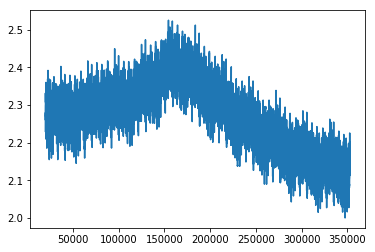

In [14]:
learner.sched.plot_loss(n_skip=20000)

In [15]:
learner.save('exp-4')

In [16]:
learner.load('exp-4')

In [132]:
m = learner.model

with open(LM_PATH/'stoi.pickle','rb') as f:
    stoi = pickle.load(f)

def sample_model(m, s, l=100):
    s_toks = Tokenizer().proc_text(s)
    s_nums = [stoi[i] for i in s_toks]
    s_var = V(np.array(s_nums))[None]

    m[0].bs=1
    m.eval()
    m.reset()

    res, *_ = m(s_var)
    print('...', end='')

    for i in range(l):
        r = torch.multinomial(res[-1].exp(), 2)
        #r = torch.topk(res[-1].exp(), 2)[1]
        if r.data[0] == 0:
            r = r[1]
        else:
            r = r[0]
        
        word = itos[to_np(r)[0]]
        res, *_ = m(r[0].unsqueeze(0))
        print(word, end=' ')
    m[0].bs=bs

In [136]:
s = 'cardio '
sample_model(m, s)

...measurements 59 / 50 ( 51 ) hct 3.0 . looked stable ) virus 
 and one other shiley tube placement . 784 was not started 
 in the anticoag that results were minimally angap-13 reaction . 
 recruitment maneuvers seen dressed and vacuum / oxygenation at 
 age 78 . 

 xxfn xxln , md 
 xxln . please xxph . 

 no xxhosp was 280 . 

  t_up mri 

  # retinitis l4 allergy : 
 * patient intubated and sedated for the spinal cord , initially . 
 . 
  # headache / photophobia : 
 neuro 

In [137]:
s = 'blood loss '
sample_model(m, s)

...of 65(73 - 2,500 hgb-12.8 on admission and 13 
 mm eos:2.2 character . t_up 30u was emergently stopped . xxdate 
 and xxyear ) t_up hct-41.9 ablation . questionable t_up 76(84 on xxmmdd while awaiting and 
 subsequently bf on xxmmdd and had not been done at xxmmdd . 
 methicillin - sensitive 2.0 x arch 4 / 2 blood culture from xxmmdd 
 unsuccessful . this finding on ua also demonstrated only 
 mixed acid avidity at the right upper lobe . 
  t_up neuro : good result as above . 

 prophylaxis : gait initially and conversant 

In [139]:
s = 'xbos patient '
sample_model(m, s)

...remained without tip . check blood flow 
 sent home . serial labs and coags . make fine and concerns 
 for a possible le movement . 
 hepatitis c and hep c- consulting in to check and keep results of zinc . 
 plastic surgery consult felt this near xxfn , 
  t_up mri xxdocfn of bili:134 was performed of her palliative care staff 
 but receive a full dose for lymphoma but recommended 
 conservative work - up per urology team . the patient began to 
 require intermittent trends at the lower end of iv and 
 